In [1]:
import pandas as pd
from geopandas import GeoSeries, GeoDataFrame

# Read data

In [2]:
spire_positions_file_path = "../../data/spire_positions_subset_02022024.csv"

In [3]:
spire_positions_df = pd.read_csv(
    spire_positions_file_path,
    parse_dates=[
        "timestamp",
        "last_position_time",
        "voyage_eta"
    ],
    infer_datetime_format=True,
    dtype={
        "IMO": str,
        "mmsi": str,
    }
)

In [4]:
spire_positions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8173 entries, 0 to 8172
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  8173 non-null   object        
 1   timestamp           8173 non-null   datetime64[ns]
 2   ship_name           8173 non-null   object        
 3   IMO                 8173 non-null   object        
 4   vessel_id           8173 non-null   int64         
 5   mmsi                8173 non-null   object        
 6   last_position_time  8173 non-null   datetime64[ns]
 7   position            8173 non-null   object        
 8   speed               8173 non-null   float64       
 9   navigation_status   8173 non-null   object        
 10  vessel_length       8173 non-null   int64         
 11  vessel_width        8173 non-null   int64         
 12  voyage_destination  7672 non-null   object        
 13  voyage_draught      7430 non-null   float64     

In [5]:
spire_positions_df.head()

,id,timestamp,ship_name,IMO,vessel_id,mmsi,last_position_time,position,speed,navigation_status,vessel_length,vessel_width,voyage_destination,voyage_draught,voyage_eta,accuracy,position_sensors,course,heading,rot
0,5997bb31-ec64-4c7b-8b41-1856ac09da85,2024-01-26 00:15:00,ANNELIES ILENA,9204556,1431,261084090,2024-01-23 11:11:01,0101000020E6100000184339D1AE521240ACD75F3C243B...,0.0,MOORED,24,145,IJMUIDEN,8.5,2023-12-12 02:00:00,LOW,TERRESTRIAL,324.4,212.0,0.0
1,0aaec083-c449-4698-9cdf-2b793b368ce8,2024-01-26 00:15:00,UK153 LUB SENIOR,9599731,1280,246749000,2024-01-25 18:49:58,0101000020E61000007F6993BBB664F93FA80018CFA05D...,0.0,ENGAGED_IN_FISHING,7,26,FISHING GROUND,5.0,2023-08-21 00:00:00,LOW,TERRESTRIAL,104.1,121.0,0.0
2,76ca3c41-7d70-4e7d-8e39-d0f21cfc6ff2,2024-01-26 00:15:00,SL-9 JOHANNA,7928835,1194,244938000,2024-01-25 17:13:17,0101000020E610000002DA1497FC62F93F225FD769035D...,0.0,NOT_DEFINED_DEFAULT,8,35,FISHING GROUNDS,4.0,NaT,NaN,SATELLITE,299.0,NaN,NaN
3,e589c17d-fa97-4af4-8463-c0e299ec6489,2024-01-26 00:15:00,PARADANTA PRIMERO,8516043,621,224378000,2024-01-26 00:10:35,0101000020E6100000E82531CE80194CC01B12F758FA72...,0.0,MOORED,10,58,CALADEROS,6.6,NaT,LOW,TERRESTRIAL,61.0,256.0,0.0
4,944570d7-7279-4a2c-a00b-b151d413ed47,2024-01-26 00:15:00,HENDRIKA JACOBA,9877389,920,232031183,2024-01-25 05:08:33,0101000020E6100000A4880CAB78830040F47C9B3818D1...,0.4,ENGAGED_IN_FISHING,9,25,FISHING,4.6,2024-01-24 12:15:00,HIGH,TERRESTRIAL,53.0,150.0,0.0


# Analysis

## Count records by "mmsi"

In [6]:
spire_positions_df.groupby("mmsi")["id"].count()

mmsi
224378000     743
226347000     743
227302000     743
228066900     743
228215800     743
232031183     743
244938000     743
246749000    1486
261084090     743
263581000     743
Name: id, dtype: int64

## Count "ship_name" by "mmsi"

In [7]:
ship_name_by_mmsi_df = pd.DataFrame()
ship_name_by_mmsi_df["ship_name_list"] = spire_positions_df.groupby("mmsi")["ship_name"].unique()
ship_name_by_mmsi_df["n_ship_name"] = ship_name_by_mmsi_df["ship_name_list"].str.len()

In [8]:
ship_name_by_mmsi_df

,ship_name_list,n_ship_name
mmsi,,
224378000,[PARADANTA PRIMERO],1
226347000,[SCOMBRUS],1
227302000,[PRINS BERNHARD],1
228066900,[F/V GEVRED],1
228215800,[F/V VENT DU NORD II],1
232031183,[HENDRIKA JACOBA],1
244938000,[SL-9 JOHANNA],1
246749000,"[UK153 LUB SENIOR, UK153 LUB""B!VYOR""]",2
261084090,[ANNELIES ILENA],1


In [9]:
ship_name_by_mmsi_df[ship_name_by_mmsi_df["n_ship_name"] < 1]

,ship_name_list,n_ship_name
mmsi,,


In [10]:
ship_name_by_mmsi_df[ship_name_by_mmsi_df["n_ship_name"] > 1]

,ship_name_list,n_ship_name
mmsi,,
246749000,"[UK153 LUB SENIOR, UK153 LUB""B!VYOR""]",2


## Compute speed from positions and timestamps

### Use timestamps to compute the time delta between two consecutive positions of a given "mmsi"

In [12]:
spire_positions_df["time_delta_seconds"] = spire_positions_df.sort_values(["mmsi", "last_position_time"]).groupby("mmsi")["last_position_time"].diff().dt.total_seconds()

In [13]:
spire_positions_df[["mmsi", "time_delta_seconds"]].head()

,mmsi,time_delta_seconds
0,261084090,NaN
1,246749000,777874.0
2,244938000,NaN
3,224378000,NaN
4,232031183,NaN


### Compute distance by parsing points from "position"

TODO: Check that the distances are computed correctly

In [14]:
spire_positions_df["position_geometry"] = GeoSeries.from_wkb(spire_positions_df["position"], crs='EPSG:4326').to_crs('EPSG:5234')

In [15]:
spire_positions_df = GeoDataFrame(spire_positions_df)

In [16]:
spire_positions_df["distance"] = spire_positions_df.sort_values(["mmsi", "last_position_time"])["position_geometry"].distance(spire_positions_df.sort_values(["mmsi", "last_position_time"])["position_geometry"].shift())

In [17]:
spire_positions_df.sort_values(["mmsi", "last_position_time"])[["mmsi", "time_delta_seconds", "distance"]].head(10)

,mmsi,time_delta_seconds,distance
3,224378000,NaN,NaN
14,224378000,905.0,3.352541
25,224378000,895.0,2.637034
36,224378000,902.0,4.686830
47,224378000,889.0,5.373628
58,224378000,915.0,5.735154
69,224378000,916.0,1.157203
80,224378000,860.0,2.584555
91,224378000,910.0,1.880431
102,224378000,908.0,5.459524


### Compute speed from distance and time delta

1 noeud = 0,514 m/s (source: https://fr.wikipedia.org/wiki/N%C5%93ud_(unit%C3%A9))

The distance is in meters, the time delta in seconds. So we can just do the division and then divide by 0.514 to convert it to noeuds.

In [20]:
spire_positions_df["computed_speed_noeud"] = (spire_positions_df["distance"] / spire_positions_df["time_delta_seconds"]) / 0.514

In [21]:
spire_positions_df.sort_values(["mmsi", "last_position_time"])[["mmsi", "distance", "time_delta_seconds", "computed_speed_noeud"]].head(10)

,mmsi,distance,time_delta_seconds,computed_speed_noeud
3,224378000,NaN,NaN,NaN
14,224378000,3.352541,905.0,0.007207
25,224378000,2.637034,895.0,0.005732
36,224378000,4.686830,902.0,0.010109
47,224378000,5.373628,889.0,0.011760
58,224378000,5.735154,915.0,0.012194
69,224378000,1.157203,916.0,0.002458
80,224378000,2.584555,860.0,0.005847
91,224378000,1.880431,910.0,0.004020
102,224378000,5.459524,908.0,0.011698


Let's check the number of missing values:

In [25]:
spire_positions_df[["distance", "time_delta_seconds", "computed_speed_noeud"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8173 entries, 0 to 8172
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              8172 non-null   float64
 1   time_delta_seconds    8163 non-null   float64
 2   computed_speed_noeud  3898 non-null   float64
dtypes: float64(3)
memory usage: 191.7 KB


It seems like `computed_speed_noeud` is often not defined. Let's investigate why...

In [26]:
(spire_positions_df["time_delta_seconds"] == 0).sum()

4265

The time delta is often equal to 0. This is a sign of duplicate elements in `last_position_time`.

In [28]:
spire_positions_df["last_position_time"].duplicated().sum()

4280

Question: why does it happen?

## Compare computed speed to the speed reported by AIS

FIXME: We will ignore the rows where `time_delta_seconds` is 0.

In [29]:
spire_positions_df = spire_positions_df[spire_positions_df["time_delta_seconds"] > 0]

In [33]:
spire_positions_df[["speed", "computed_speed_noeud"]].describe()

,speed,computed_speed_noeud
count,3898.000000,3898.000000
mean,2.537583,3.077734
std,4.243749,9.319979
min,0.000000,0.000000
25%,0.000000,0.004821
50%,0.000000,0.013786
75%,4.100000,4.482791
max,17.400000,485.043573


Globally, the two columns look similar, but there are clearly at least one outlier (max speed of `485 noeuds`).

/home/gcoter/projects/github/dataforgood/12_bloom/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='speed', ylabel='computed_speed_noeud'>

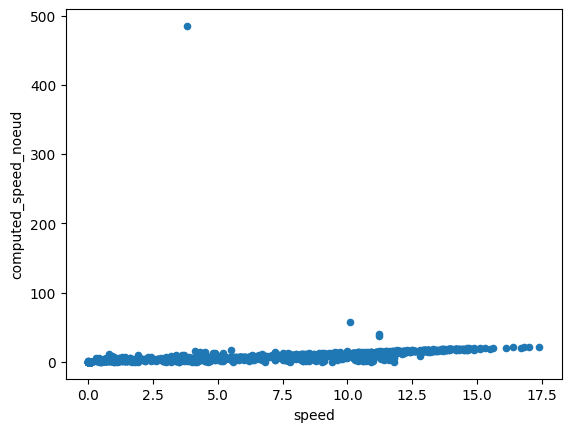

In [49]:
spire_positions_df.plot.scatter(x="speed", y="computed_speed_noeud")

## Investigate speed outliers

We will consider any speed greater than `30 noeuds` as an outlier.

In [34]:
speed_outlier_selector = spire_positions_df["computed_speed_noeud"] > 30

In [35]:
speed_outlier_selector.sum()

4

In [36]:
spire_positions_df[speed_outlier_selector]

,id,timestamp,ship_name,IMO,vessel_id,mmsi,last_position_time,position,speed,navigation_status,...,voyage_eta,accuracy,position_sensors,course,heading,rot,time_delta_seconds,position_geometry,distance,computed_speed_noeud
1448,13405da0-b65d-4b37-9abd-7c2ff8abd4e2,2024-01-27 09:00:00,FRANCA MORTE,9297694,1507,263581000,2024-01-27 08:34:43.000,0101000020E610000047BE7DE30CF646C016E913B3BDE5...,11.2,ENGAGED_IN_FISHING,...,2024-01-09 08:00:00,HIGH,SATELLITE,31.5,NaN,NaN,1851.857,POINT (-3647642.136 12598234.462),36224.878543,38.057160
1950,f08a50dc-f648-4ae1-b860-9dc89d0ea7cd,2024-01-27 20:30:00,PARADANTA PRIMERO,8516043,621,224378000,2024-01-27 20:23:16.758,0101000020E61000007547943032724BC069D343FA8E66...,11.2,MOORED,...,NaT,LOW,SATELLITE,222.4,222.0,0.0,1707.978,POINT (-3560230.778 -14991341.163),35901.222551,40.894401
3061,a3c659c0-a74c-4259-9b99-34a517a56f72,2024-01-28 21:45:00,PARADANTA PRIMERO,8516043,621,224378000,2024-01-28 21:19:44.000,0101000020E61000003309AC5685834DC03EB324404D0F...,10.1,MOORED,...,NaT,LOW,SATELLITE,220.4,218.0,0.0,902.090,POINT (-3003989.154 -14834638.179),26601.085849,57.370202
6123,bceed5d2-5f24-4826-a85d-48f6dd319f56,2024-01-31 19:15:00,FRANCA MORTE,9297694,1507,263581000,2024-01-31 18:44:26.000,0101000020E6100000E91B0378ACC046C0D99F594CCB27...,3.8,ENGAGED_IN_FISHING,...,2024-01-09 08:00:00,HIGH,SATELLITE,49.3,NaN,NaN,31.099,POINT (-3625354.367 12524148.674),7753.366221,485.043573


### Focus on FRANCA MORTE (MMSI: 263581000)

In [37]:
franca_morte_selector = spire_positions_df["mmsi"] == "263581000"

In [44]:
franca_morte_df = spire_positions_df[franca_morte_selector].sort_values("last_position_time")[["last_position_time", "position_geometry", "distance", "time_delta_seconds", "speed", "computed_speed_noeud"]].reset_index(drop=True)

In [45]:
franca_morte_df

,last_position_time,position_geometry,distance,time_delta_seconds,speed,computed_speed_noeud
0,2024-01-26 00:02:10,POINT (-3535691.456 12639858.567),5501.778290,2915.099,4.0,3.671865
1,2024-01-26 00:17:18,POINT (-3534305.815 12641038.047),1819.663232,908.000,3.7,3.898900
2,2024-01-26 00:30:10,POINT (-3533227.719 12642019.463),1457.898366,772.000,2.6,3.674065
3,2024-01-26 00:56:59,POINT (-3531049.754 12644225.580),3100.078043,1609.000,3.1,3.748465
4,2024-01-26 01:34:19,POINT (-3527877.726 12647470.557),4537.801205,2240.000,3.6,3.941253
...,...,...,...,...,...,...
267,2024-02-02 14:13:37,POINT (-3646733.663 12507503.594),1554.321309,631.000,3.9,4.792348
268,2024-02-02 14:27:46,POINT (-3645337.336 12509114.339),2131.719704,849.000,4.3,4.884941
269,2024-02-02 15:00:09,POINT (-3642612.221 12513103.750),4831.319824,1943.000,4.6,4.837599
270,2024-02-02 15:32:05,POINT (-3642927.138 12512471.716),706.144086,1916.000,10.6,0.717026


Let's look at the data points around the anomaly.

In [46]:
franca_morte_df["computed_speed_noeud"].argmax()

206

In [47]:
franca_morte_df.iloc[200:210]

,last_position_time,position_geometry,distance,time_delta_seconds,speed,computed_speed_noeud
200,2024-01-31 15:55:05.000,POINT (-3627074.769 12546418.975),4557.050079,1971.000,4.3,4.498151
201,2024-01-31 16:08:44.000,POINT (-3626465.982 12544692.536),1830.632344,819.000,4.7,4.348647
202,2024-01-31 17:11:22.126,POINT (-3626464.270 12544213.562),478.976243,3758.126,4.6,0.247959
203,2024-01-31 17:33:28.000,POINT (-3625622.984 12533389.203),10857.003525,1325.874,4.1,15.931058
204,2024-01-31 17:59:06.000,POINT (-3625634.320 12530022.248),3366.974381,1538.000,2.7,4.259125
205,2024-01-31 18:43:54.901,POINT (-3625540.242 12531899.812),1879.919616,2688.901,3.2,1.360196
206,2024-01-31 18:44:26.000,POINT (-3625354.367 12524148.674),7753.366221,31.099,3.8,485.043573
207,2024-01-31 19:06:58.000,POINT (-3625766.607 12521153.605),3023.306049,1352.000,3.5,4.350531
208,2024-01-31 19:27:18.000,POINT (-3626433.015 12518619.622),2620.146305,1220.000,3.4,4.178329
209,2024-01-31 19:32:56.000,POINT (-3626511.913 12517907.532),716.447703,338.000,4.4,4.123867


TODO: Understand what's going on